In [1]:
import pandas as pd
import numpy as np

In [2]:
dt_2014 = pd.read_csv("datasets/constituency_wise_results_2014.csv")
dt_2019 = pd.read_csv("datasets/constituency_wise_results_2019.csv")

In [3]:
dt_2014.sample(5)

,state,pc_name,candidate,sex,age,category,party,party_symbol,general_votes,postal_votes,total_votes,total_electors
2001,Haryana,Sonipat,SITENDER SINGH,M,36.0,GEN,IND,Television,899,0,899,1417188
8081,Uttarakhand,Nainital-udhamsingh Nagar,BHUWAN CHANDRA JOSHI,M,46.0,GEN,IND,Cup & Saucer,3180,0,3180,1610811
5175,Tamil Nadu,Vellore,"ABDUL RAHMAN, N.",M,57.0,GEN,IND,Candles,581,0,581,1312259
3962,Maharashtra,Mumbai South central,EKNATH M. GAIKWAD,M,74.0,GEN,INC,Hand,242701,127,242828,1447886
106,Andhra Pradesh,Malkajgiri,DASARI BHARATH REDDY,M,28.0,GEN,IND,Cup & Saucer,1693,0,1693,3183083


In [4]:
dt_2019.loc[(dt_2019['party'] == "NOTA"), 'party_symbol'] = 'NOTA'

In [5]:
def data_corrector(dataframe):
    dataframe["pc_name"] = np.where((dataframe["state"] == "Himachal Pradesh") & (dataframe["pc_name"] == "Hamirpur"), "Hamirpur (Himachal Pradesh)",
    np.where((dataframe["state"] == "Bihar") & (dataframe["pc_name"] == "Aurangabad"), "Aurangabad (Bihar)",
    np.where((dataframe["state"] == "Bihar") & (dataframe["pc_name"] == "Maharajganj"), "Maharajganj (Bihar)",
    np.where((dataframe["state"] == "Uttar Prades") & (dataframe["pc_name"] == "Hamirpur"), "Hamirpur (Uttar Prades)",
    np.where((dataframe["state"] == "Uttar Prades") & (dataframe["pc_name"] == "Maharajganj"), "Maharajganj (Uttar Prades)",
    np.where((dataframe["state"] == "Maharashtra") & (dataframe["pc_name"] == "Aurangabad"), "Aurangabad (Maharashtra)",dataframe["pc_name"]))))))

In [6]:
data_corrector(dt_2014)
data_corrector(dt_2019)

In [7]:
Telangana_pc_name = ['Adilabad','Peddapalle','Karimnagar','Nizamabad','Zahirabad','Medak','Malkajgiri','Secundrabad','Hyderabad','CHEVELLA','Mahbubnagar','Nagarkurnool','Nalgonda','Bhongir','Warangal','Mahabubabad','Khammam']

In [8]:
dt_2014.loc[dt_2014['pc_name'].isin(Telangana_pc_name), 'state'] = 'Telangana'

In [9]:
canges_for_2014 = {"Dadar & Nagar Haveli":"Dadra And Nagar Haveli","Joynagar":"Jaynagar"}
canges_for_2019 = {"Bikaner (SC)":"Bikaner","CHEVELLA":"CHELVELLA"}

In [10]:
dt_2014["pc_name"] = dt_2014["pc_name"].replace(canges_for_2014)
dt_2019["pc_name"] = dt_2019["pc_name"].replace(canges_for_2019)

In [11]:
dt_2014["party"] = (dt_2014["party"]+ " , " +dt_2014["party_symbol"])
dt_2019["party"] = (dt_2019["party"]+ " , " +dt_2019["party_symbol"])

# 1

In [12]:
group = dt_2014.groupby("pc_name")

temp_df1 = group["total_votes"].sum().to_frame()

temp_df2 = group["total_electors"].apply(lambda x: x.mode().iloc[0]).to_frame()

df = pd.merge(temp_df1,temp_df2, on = "pc_name")

df["Turnout Ratio"] = round((df["total_votes"] / df["total_electors"])*100,1)

In [13]:
print("top 5 constituencies of 2014 in terms of voter turnout ratio.")
df.sort_values("Turnout Ratio",ascending = False).head(5)

top 5 constituencies of 2014 in terms of voter turnout ratio.


,total_votes,total_electors,Turnout Ratio
pc_name,,,
Dhubri,1369624,1550166,88.4
Nagaland,1038910,1182972,87.8
Tamluk,1337684,1527273,87.6
Bishnupur,1272070,1466921,86.7
Kanthi,1290811,1490409,86.6


In [14]:
print("bottom 5 constituencies of 2014 in terms of voter turnout ratio.")
df.sort_values("Turnout Ratio").head(5)

bottom 5 constituencies of 2014 in terms of voter turnout ratio.


,total_votes,total_electors,Turnout Ratio
pc_name,,,
Srinagar,312212,1207230,25.9
Anantnag,375279,1301143,28.8
Baramulla,465992,1190766,39.1
Kalyan,824196,1922034,42.9
Patna Sahib,882262,1946249,45.3


In [15]:
group = dt_2019.groupby("pc_name")

In [16]:
temp_df1 = group["total_votes"].sum().to_frame()

In [17]:
temp_df2 = group["total_electors"].apply(lambda x: x.mode().iloc[0]).to_frame()

In [18]:
df = pd.merge(temp_df1,temp_df2, on = "pc_name")

In [19]:
df["Turnout Ratio"] = round((df["total_votes"] / df["total_electors"])*100,1)

In [20]:
print("top 5 constituencies of 2019 in terms of voter turnout ratio.")
df.sort_values("Turnout Ratio",ascending = False).head(5)

top 5 constituencies of 2019 in terms of voter turnout ratio.


,total_votes,total_electors,Turnout Ratio
pc_name,,,
Dhubri,1685005,1858566,90.7
Bishnupur,1420648,1627199,87.3
Barpeta,1458549,1685149,86.6
ARUNACHAL EAST,293781,339788,86.5
Jalpaiguri,1500922,1735464,86.5


In [21]:
print("bottom 5 constituencies of 2019 in terms of voter turnout ratio.")
df.sort_values("Turnout Ratio").head(5)

bottom 5 constituencies of 2019 in terms of voter turnout ratio.


,total_votes,total_electors,Turnout Ratio
pc_name,,,
Anantnag,124896,1397779,8.9
Srinagar,186832,1294671,14.4
Baramulla,455550,1317738,34.6
Hyderabad,877872,1957931,44.8
Kalyan,890313,1965676,45.3


# 2




In [22]:
group = dt_2014.groupby("pc_name")

temp_df1 = group["total_votes"].sum().to_frame()

temp_df2 = group["total_electors"].apply(lambda x: x.mode().iloc[0]).to_frame()

temp_df3 = group["state"].apply(lambda x: x.unique()[0]).to_frame()

df = pd.merge(temp_df1,temp_df2, on = "pc_name")

df = pd.merge(df,temp_df3, on = "pc_name")

df.set_index("state", inplace = True)

df = df.groupby("state").sum()

df["Turnout Ratio"] = round((df["total_votes"] / df["total_electors"])*100,1)

In [23]:
print("top 5 states of 2014 in terms of voter turnout ratio.")
df.sort_values("Turnout Ratio",ascending = False).head(5)

top 5 states of 2014 in terms of voter turnout ratio.


,total_votes,total_electors,Turnout Ratio
state,,,
Nagaland,1038910,1182972,87.8
Lakshadweep,43239,49922,86.6
Tripura,2023829,2388822,84.7
Dadra & Nagar Haveli,165286,196597,84.1
Sikkim,308967,370770,83.3


In [24]:
print("bottom 5 states of 2014 in terms of voter turnout ratio.")
df.sort_values("Turnout Ratio").head(5)

bottom 5 states of 2014 in terms of voter turnout ratio.


,total_votes,total_electors,Turnout Ratio
state,,,
Jammu & Kashmir,3566863,7183129,49.7
Bihar,35885332,63800160,56.2
Uttar Pradesh,81093120,138810557,58.4
Maharashtra,48717419,80798823,60.3
Madhya Pradesh,29639807,48121301,61.6


In [25]:
group = dt_2019.groupby("pc_name")

In [26]:
temp_df1 = group["total_votes"].sum().to_frame()

In [27]:
temp_df2 = group["total_electors"].apply(lambda x: x.mode().iloc[0]).to_frame()

In [28]:
temp_df3 = group["state"].apply(lambda x: x.unique()[0]).to_frame()

In [29]:
df = pd.merge(temp_df1,temp_df2, on = "pc_name")

In [30]:
df = pd.merge(df,temp_df3, on = "pc_name")

In [31]:
df.set_index("state", inplace = True)

In [32]:
df = df.groupby("state").sum()

In [33]:
df["Turnout Ratio"] = round((df["total_votes"] / df["total_electors"])*100,1)

In [34]:
print("top 5 states of 2019 in terms of voter turnout ratio.")
df.sort_values("Turnout Ratio",ascending = False).head(5)

top 5 states of 2019 in terms of voter turnout ratio.


,total_votes,total_electors,Turnout Ratio
state,,,
Lakshadweep,47009,55189,85.2
Nagaland,1006357,1213777,82.9
Manipur,1617330,1959563,82.5
Tripura,2153172,2614718,82.3
West Bengal,57206976,70001284,81.7


In [35]:
print("bottom 5 states of 2019 in terms of voter turnout ratio.")
df.sort_values("Turnout Ratio").head(5)

bottom 5 states of 2019 in terms of voter turnout ratio.


,total_votes,total_electors,Turnout Ratio
state,,,
Jammu & Kashmir,3552622,7922538,44.8
Bihar,40806661,71216290,57.3
Uttar Pradesh,86481398,146134603,59.2
NCT OF Delhi,8679012,14327649,60.6
Maharashtra,54054245,88676946,61.0


# 3

In [36]:
dt_14 = dt_2014[["pc_name","party","total_votes","total_electors"]].groupby("pc_name").apply(lambda x: x.loc[x["total_votes"].idxmax()]).reset_index(drop=True)
dt_19 = dt_2019[["pc_name","party","total_votes","total_electors"]].groupby("pc_name").apply(lambda x: x.loc[x["total_votes"].idxmax()]).reset_index(drop=True)

In [37]:
df = pd.merge(dt_14,dt_19, on = "pc_name", suffixes=('_14', '_19'))

In [38]:
df = df[df["party_14"] == df["party_19"]]

In [39]:
df["percentage_14"] = round(((df["total_votes_14"]/df["total_electors_14"])*100),2)
df["percentage_19"] = round(((df["total_votes_19"]/df["total_electors_19"])*100),2)

In [40]:
df = df.sort_values("percentage_19",ascending = False)[["pc_name","party_14","percentage_14","percentage_19"]]

In [41]:
print("constituencies which elected the same party for two consecutive elections, rank them by % of votes to that winning party in 2019.")
df.rename(columns={"party_14":"party","pc_name":"constituencies"}).set_index("constituencies").head(15)

constituencies which elected the same party for two consecutive elections, rank them by % of votes to that winning party in 2019.


,party,percentage_14,percentage_19
constituencies,,,
Wayanad,"INC , Hand",30.18,51.95
HOSHANGABAD,"BJP , Lotus",42.67,51.46
Kangra,"BJP , Lotus",36.24,50.81
Uttara Kannada,"BJP , Lotus",37.70,50.50
Mandi,"BJP , Lotus",31.54,50.50
Dibrugarh,"BJP , Lotus",43.97,50.18
Hamirpur (Himachal Pradesh),"BJP , Lotus",35.91,50.11
Kadapa,"YSRCP , Ceiling Fan",43.34,49.89
Navsari,"BJP , Lotus",46.52,49.34


# 4

In [42]:
dt_14 = dt_2014[["pc_name","party","total_votes","total_electors"]].groupby("pc_name").apply(lambda x: x.loc[x["total_votes"].idxmax()]).reset_index(drop=True)
dt_19 = dt_2019[["pc_name","party","total_votes","total_electors"]].groupby("pc_name").apply(lambda x: x.loc[x["total_votes"].idxmax()]).reset_index(drop=True)

df = pd.merge(dt_14,dt_19, on = "pc_name", suffixes=('_14', '_19'))

df = df[df["party_14"] != df["party_19"]]

df["percentage_14"] = round(((df["total_votes_14"]/df["total_electors_14"])*100),2)
df["percentage_19"] = round(((df["total_votes_19"]/df["total_electors_19"])*100),2)
df["diffrence"] = df["percentage_19"] - df["percentage_14"]

df = df.sort_values("diffrence",ascending = False)[["pc_name","party_14","percentage_14","party_19","percentage_19","diffrence"]]

print("top 10 constituencies which voted for different parties in two elections \non the based of difference (2019-2014) in winner vote percentage in two elections.")
df.rename(columns={"pc_name":"constituencies"}).set_index("constituencies").head(10)

top 10 constituencies which voted for different parties in two elections 
on the based of difference (2019-2014) in winner vote percentage in two elections.


,party_14,percentage_14,party_19,percentage_19,diffrence
constituencies,,,,,
Alipurduars,"AITC , Flowers and Grass",24.64,"BJP , Lotus",45.55,20.91
Autonomous District,"INC , Hand",30.35,"BJP , Lotus",47.91,17.56
Puducherry,"AINRC , Jug",28.38,"INC , Hand",45.71,17.33
Kanniyakumari,"BJP , Lotus",25.41,"INC , Hand",41.78,16.37
Chikkballapur,"INC , Hand",25.61,"BJP , Lotus",41.24,15.63
Kolar,"INC , Hand",28.06,"BJP , Lotus",43.51,15.45
Sambhal,"BJP , Lotus",21.28,"SP , Bicycle",35.98,14.70
Supaul,"INC , Hand",21.82,"JD(U) , Arrow",35.33,13.51
Giridih,"BJP , Lotus",25.93,"AJSUP , Banana",39.30,13.37


# 5

In [43]:
def rank_by_margin(data,n):
    df1 = data[["pc_name","candidate","total_votes","party"]].groupby("pc_name").apply(lambda x: x.loc[x["total_votes"].idxmax()]).reset_index(drop=True)
    df2 = data[["pc_name","candidate","total_votes","state","party"]].groupby("pc_name").apply(lambda x: x.sort_values("total_votes", ascending = False )[1:].head(1)).reset_index(drop=True)

    df = pd.merge(df1,df2, on = "pc_name", suffixes=('_f', '_s'))

    df["margin"] = df["total_votes_f"] - df["total_votes_s"]

    df = df.sort_values(by = "margin",ascending = False)[["state","pc_name","candidate_f","party_f","total_votes_f","candidate_s","party_s","total_votes_s","margin"]]

    return df.rename(columns={"pc_name":"constituencies","candidate_f":"candidate","party_f":"candidate party","total_votes_f":"candidate total votes","candidate_s":"runner","party_s":"runner party","total_votes_s":"runner total votes"}).set_index("state").head(n)

In [44]:
print("Top 5 candidates based on margin difference with runners in 2014.")
rank_by_margin(dt_2014,5)

Top 5 candidates based on margin difference with runners in 2014.


,constituencies,candidate,candidate party,candidate total votes,runner,runner party,runner total votes,margin
state,,,,,,,,
Gujarat,Vadodara,NARENDRA MODI,"BJP , Lotus",845464,MISTRI MADHUSUDAN DEVRAM,"INC , Hand",275336,570128
Uttar Pradesh,Ghaziabad,VIJAY KUMAR SINGH,"BJP , Lotus",758482,RAJ BABBAR,"INC , Hand",191222,567260
Gujarat,Navsari,C. R. PATIL,"BJP , Lotus",820831,MAKSUD MIRZA,"INC , Hand",262715,558116
Rajasthan,Jaipur,RAMCHARAN BOHARA,"BJP , Lotus",863358,DR. MAHESH JOSHI,"INC , Hand",324013,539345
Gujarat,Surat,DARSHANA VIKRAM JARDOSH,"BJP , Lotus",718412,DESAI NAISHADHBHAI BHUPATBHAI,"INC , Hand",185222,533190


In [45]:
print("Top 5 candidates based on margin difference with runners in 2019.")
rank_by_margin(dt_2019,5)

Top 5 candidates based on margin difference with runners in 2019.


,constituencies,candidate,candidate party,candidate total votes,runner,runner party,runner total votes,margin
state,,,,,,,,
Gujarat,Navsari,C. R. Patil,"BJP , Lotus",972739,PATEL DHARMESHBHAI BHIMBHAI,"INC , Hand",283071,689668
Haryana,Karnal,Sanjay Bhatia,"BJP , Lotus",911594,Kuldip Sharma,"INC , Hand",255452,656142
Haryana,Faridabad,KRISHAN PAL,"BJP , Lotus",913222,AVTAR SINGH BHADANA,"INC , Hand",274983,638239
Rajasthan,Bhilwara,SUBHASH CHANDRA BAHERIA,"BJP , Lotus",938160,RAM PAL SHARMA,"INC , Hand",326160,612000
Gujarat,Vadodara,RANJANBEN BHATT,"BJP , Lotus",883719,PRASHANT PATEL (TIKO),"INC , Hand",294542,589177


# 6

In [46]:
df_14 = dt_2014.groupby("party")["total_votes"].sum().reset_index()
df_19 = dt_2019.groupby("party")["total_votes"].sum().reset_index()

In [47]:
total_vote_14 = dt_2014["total_votes"].sum()
total_vote_19 = dt_2019["total_votes"].sum()

In [48]:
df_14["% votes"] = ((df_14["total_votes"] / total_vote_14)*100)
df_19["% votes"] = ((df_19["total_votes"] / total_vote_19)*100)

In [49]:
final_dt = pd.merge(df_14[["party","% votes"]],df_19[["party","% votes"]], on = "party", suffixes = ("_14","_19"))

In [50]:
final_dt["change_in_vote_share_%"] = final_dt["% votes_19"] - final_dt["% votes_14"]

In [51]:
print("% Split of votes of parties between 2014 vs 2019 at national level")
final_dt.sort_values(by = "change_in_vote_share_%", ascending = False).set_index("party").rename(columns = {"% votes_14":"% votes in 2014","% votes_19":"% votes in 2019"})

% Split of votes of parties between 2014 vs 2019 at national level


,% votes in 2014,% votes in 2019,change_in_vote_share_%
party,,,
"BJP , Lotus",30.969622,37.298440,6.328817
"INC , Hand",18.584291,19.456285,0.871994
"DMK , Rising Sun",1.852097,2.338647,0.486550
"JD(U) , Arrow",1.150845,1.452418,0.301573
"AGP , Elephant",0.111098,0.241088,0.129990
...,...,...,...
"BSP , Elephant",4.314084,3.622189,-0.691895
"SP , Bicycle",3.581270,2.545964,-1.035306
"AAAP , Broom",2.122389,0.442323,-1.680066


# 7

In [52]:
df_14 = dt_2014.groupby(["state","party"])["total_votes"].sum().reset_index()
df_19 = dt_2019.groupby(["state","party"])["total_votes"].sum().reset_index()

total_vote_14 = dt_2014.groupby("state")["total_votes"].sum()
total_vote_19 = dt_2019.groupby("state")["total_votes"].sum()
df_14 = pd.merge(df_14 , total_vote_14, on = "state", suffixes = ("_p","_s"))
df_19 = pd.merge(df_19 , total_vote_19, on = "state", suffixes = ("_p","_s"))

df_14["% votes"] = ((df_14["total_votes_p"] / df_14["total_votes_s"])*100)
df_19["% votes"] = ((df_19["total_votes_p"] / df_19["total_votes_s"])*100)

final_dt = pd.merge(df_14,df_19, on = ["state","party"], suffixes = ("_14","_19"), how = "inner")

final_dt["change_in_vote_share_%"] = final_dt["% votes_19"] - final_dt["% votes_14"]
print("% Split of votes of parties between 2014 vs 2019 at state level.")
final_dt[["party","state","% votes_14","% votes_19","change_in_vote_share_%"]].set_index("state").rename(columns = {"% votes_14":"% votes in 2014","% votes_19":"% votes in 2019"})

% Split of votes of parties between 2014 vs 2019 at state level.


,party,% votes in 2014,% votes in 2019,change_in_vote_share_%
state,,,,
Andaman & Nicobar Islands,"AAAP , Broom",1.963453,1.369539,-0.593913
Andaman & Nicobar Islands,"AITC , Flowers and Grass",1.199508,0.830214,-0.369294
Andaman & Nicobar Islands,"BJP , Lotus",47.795910,45.298028,-2.497882
Andaman & Nicobar Islands,"BSP , Elephant",0.598441,1.199251,0.600811
Andaman & Nicobar Islands,"INC , Hand",43.691417,45.976768,2.285351
...,...,...,...,...
West Bengal,"JMM , Bow & Arrow",0.119018,0.004949,-0.114069
West Bengal,"NOTA , NOTA",1.106476,0.955807,-0.150670
West Bengal,"RJNP , HOCKEY & BALL",0.035269,0.015049,-0.020220


# 8

In [53]:
top_parties = list(dt_2014.groupby("party")["total_votes"].sum().sort_values(ascending = False).head(2).index)

df_14 = dt_2014[dt_2014["party"].isin(top_parties)].groupby(["pc_name","party"])["total_votes"].sum().reset_index()
df_19 = dt_2019[dt_2019["party"].isin(top_parties)].groupby(["pc_name","party"])["total_votes"].sum().reset_index()

total_vote_14 = dt_2014.groupby("pc_name")["total_votes"].sum()
total_vote_19 = dt_2019.groupby("pc_name")["total_votes"].sum()
df_14 = pd.merge(df_14 , total_vote_14, on = "pc_name", suffixes = ("_p","_s"))
df_19 = pd.merge(df_19 , total_vote_19, on = "pc_name", suffixes = ("_p","_s"))

df_14["% votes"] = ((df_14["total_votes_p"] / df_14["total_votes_s"])*100)
df_19["% votes"] = ((df_19["total_votes_p"] / df_19["total_votes_s"])*100)

final_dt = pd.merge(df_14,df_19, on = ["pc_name","party"], suffixes = ("_14","_19"), how = "inner")

final_dt["change_in_vote_share_%"] = final_dt["% votes_19"] - final_dt["% votes_14"]

final_dt = final_dt.groupby("party").apply(lambda x: x.sort_values("change_in_vote_share_%", ascending = False ).head(5)).reset_index(drop=True)
print(" top 5 constituencies for two major national parties where they have gained vote share in 2019 as compared to 2014.")
final_dt[["party","pc_name","% votes_14","% votes_19","change_in_vote_share_%"]].set_index("pc_name").rename(columns = {"% votes_14":"% votes in 2014","% votes_19":"% votes in 2019"})

 top 5 constituencies for two major national parties where they have gained vote share in 2019 as compared to 2014.


,party,% votes in 2014,% votes in 2019,change_in_vote_share_%
pc_name,,,,
Tripura West,"BJP , Lotus",5.099609,51.774264,46.674656
Purulia,"BJP , Lotus",7.158445,49.298203,42.139758
Tripura East,"BJP , Lotus",6.373071,46.118056,39.744986
Ranaghat,"BJP , Lotus",17.268008,52.778607,35.510598
Jhargram,"BJP , Lotus",9.737415,44.558154,34.820739
Karur,"INC , Hand",2.910464,63.063730,60.153266
Tiruchirappalli,"INC , Hand",5.214976,59.279413,54.064437
Arani,"INC , Hand",2.528817,54.004390,51.475573
Thiruvallur,"INC , Hand",3.504353,54.487856,50.983504


# 9 

In [54]:
top_parties = list(dt_2014.groupby("party")["total_votes"].sum().sort_values(ascending = False).head(2).index)

df_14 = dt_2014[dt_2014["party"].isin(top_parties)].groupby(["pc_name","party"])["total_votes"].sum().reset_index()
df_19 = dt_2019[dt_2019["party"].isin(top_parties)].groupby(["pc_name","party"])["total_votes"].sum().reset_index()

total_vote_14 = dt_2014.groupby("pc_name")["total_votes"].sum()
total_vote_19 = dt_2019.groupby("pc_name")["total_votes"].sum()
df_14 = pd.merge(df_14 , total_vote_14, on = "pc_name", suffixes = ("_p","_s"))
df_19 = pd.merge(df_19 , total_vote_19, on = "pc_name", suffixes = ("_p","_s"))

df_14["% votes"] = ((df_14["total_votes_p"] / df_14["total_votes_s"])*100)
df_19["% votes"] = ((df_19["total_votes_p"] / df_19["total_votes_s"])*100)

final_dt = pd.merge(df_14,df_19, on = ["pc_name","party"], suffixes = ("_14","_19"), how = "inner")

final_dt["change_in_vote_share_%"] = final_dt["% votes_19"] - final_dt["% votes_14"]

final_dt = final_dt.groupby("party").apply(lambda x: x.sort_values( by = "change_in_vote_share_%").head(5)).reset_index(drop=True)
print("top 5 constituencies for two major national parties where they have lost vote share in 2019 as compared to 2014.")
final_dt[["party","pc_name","% votes_14","% votes_19","change_in_vote_share_%"]].set_index("pc_name").rename(columns = {"% votes_14":"% votes in 2014","% votes_19":"% votes in 2019"})

top 5 constituencies for two major national parties where they have lost vote share in 2019 as compared to 2014.


,party,% votes in 2014,% votes in 2019,change_in_vote_share_%
pc_name,,,,
Narsapuram,"BJP , Lotus",49.617291,1.054054,-48.563236
Visakhapatnam,"BJP , Lotus",48.715406,2.733768,-45.981638
Tirupati,"BJP , Lotus",44.758718,1.227622,-43.531096
Sangli,"BJP , Lotus",58.430014,42.774199,-15.655815
Daman & diu,"BJP , Lotus",53.832838,42.983228,-10.849610
Dadra And Nagar Haveli,"INC , Hand",45.119369,4.325998,-40.793371
Ratnagiri - sindhudurg,"INC , Hand",38.274444,7.024621,-31.249823
Aurangabad (Maharashtra),"INC , Hand",36.513374,7.660440,-28.852934
ARUNACHAL WEST,"INC , Hand",38.022731,14.220368,-23.802363


# 10

In [55]:
def top_NOTA(dt):
    data = dt[dt["party"] == "NOTA , NOTA"][["pc_name","total_votes"]]

    return data.sort_values(by = "total_votes", ascending = False).rename(columns = {"pc_name":"constituencies"}).set_index("constituencies").head(5)

In [56]:
print("constituency which has voted the most for NOTA in 2014.")
top_NOTA(dt_2014)

constituency which has voted the most for NOTA in 2014.


,total_votes
constituencies,
Nilgiris,46559
Banswara,34404
Dahod,32305
RATLAM,30364
Samastipur (SC),29211


In [57]:
print("constituency which has voted the most for NOTA in 2019")
top_NOTA(dt_2019)

constituency which has voted the most for NOTA in 2019


,total_votes
constituencies,
Gopalganj (SC),51660
Aruku,47977
Paschim Champaran,45699
Nabarangpur,44582
BASTAR,41667


# 11

In [58]:
df_19 = dt_2019.groupby(["state","party"])["total_votes"].sum().reset_index()

total_vote_19 = dt_2019.groupby("state")["total_votes"].sum()

df_19 = pd.merge(df_19 , total_vote_19, on = "state", suffixes = ("_p","_s"))

df_19["% votes"] = ((df_19["total_votes_p"] / df_19["total_votes_s"])*100)

In [59]:
df1 = dt_2019[["state","pc_name","candidate","total_votes","party"]].groupby("pc_name").apply(lambda x: x.loc[x["total_votes"].idxmax()]).reset_index(drop=True)

In [60]:
finaldf = pd.merge(df_19[["state","party","% votes"]], df1[["state","pc_name","candidate","party"]], on = ["state","party"], suffixes = ("_p","_s"))

In [61]:
print("constituencies which have elected candidates whose party has less than 10% vote share at state level in 2019")
finaldf[finaldf["% votes"] <= 10][["pc_name","candidate","party","% votes"]].rename(columns = {"pc_name":"constituencies"}).set_index("constituencies")

constituencies which have elected candidates whose party has less than 10% vote share at state level in 2019


,candidate,party,% votes
constituencies,,,
Dhubri,BADRUDDIN AJMAL,"AIUDF , Lock and Key",7.795412
Kokrajhar,Naba Kumar Sarania,"IND , Battery Torch",2.914161
Kishanganj,Dr. Mohammad Jawed,"INC , Hand",7.696775
Hajipur (SC),PASHU PATI KUMAR PARAS,"LJP , Bungalow",7.858960
Jamui (SC),CHIRAG KUMAR PASWAN,"LJP , Bungalow",7.858960
Khagaria,Choudhary Mehboob Ali Kaiser,"LJP , Bungalow",7.858960
Nawada,Chandan Singh,"LJP , Bungalow",7.858960
Samastipur (SC),Ramchandra Paswan,"LJP , Bungalow",7.858960
Vaishali,Veena Devi (W/o Dinesh Prasad Singh),"LJP , Bungalow",7.858960


# visual analysis

In [62]:
import matplotlib.pyplot as plt

# 1

In [63]:
group = dt_2014.groupby("pc_name")

temp_df1 = group[["total_votes","postal_votes"]].sum()

temp_df2 = group["total_electors"].apply(lambda x: x.mode().iloc[0]).to_frame()

df = pd.merge(temp_df1,temp_df2, on = "pc_name")

df["Turnout Ratio"] = round((df["total_votes"] / df["total_electors"])*100)
df["% postal_votes"] = (df["postal_votes"] / df["total_votes"])*100

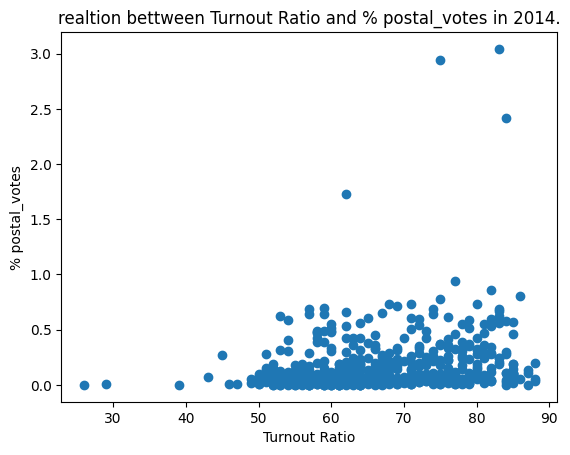

In [64]:
plt.scatter(df["Turnout Ratio"],df["% postal_votes"])
plt.title('realtion bettween Turnout Ratio and % postal_votes in 2014.')
plt.xlabel('Turnout Ratio')
plt.ylabel('% postal_votes')
plt.show()

In [65]:
group = dt_2019.groupby("pc_name")

temp_df1 = group[["total_votes","postal_votes"]].sum()

temp_df2 = group["total_electors"].apply(lambda x: x.mode().iloc[0]).to_frame()

df = pd.merge(temp_df1,temp_df2, on = "pc_name")

df["Turnout Ratio"] = round((df["total_votes"] / df["total_electors"])*100)
df["% postal_votes"] = (df["postal_votes"] / df["total_votes"])*100

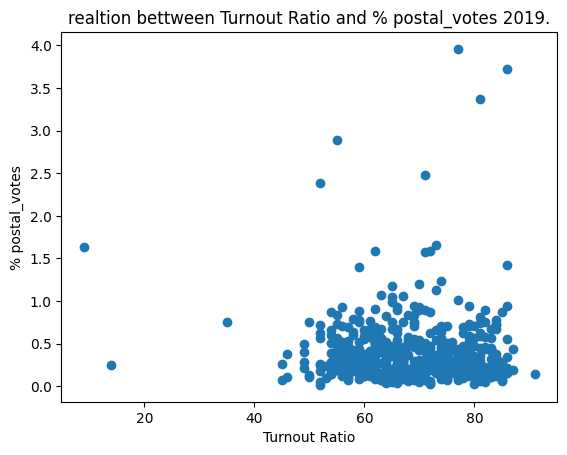

In [66]:
plt.scatter(df["Turnout Ratio"],df["% postal_votes"])
plt.title('realtion bettween Turnout Ratio and % postal_votes 2019.')
plt.xlabel('Turnout Ratio')
plt.ylabel('% postal_votes')
plt.show()

# 2

In [67]:
data = {
    'state': [
        'Andhra Pradesh', 'Telangana', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Goa', 'Gujarat', 
        'Haryana', 'Himachal Pradesh', 'Jammu & Kashmir', 'Karnataka', 'Kerala', 'Madhya Pradesh', 
        'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Punjab', 'Rajasthan', 
        'Sikkim', 'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'West Bengal', 'Jharkhand', 'Uttarakhand', 
        'Andaman & Nicobar Islands', 'Chandigarh', 'Dadra & Nagar Haveli', 'Daman & Diu', 'NCT OF Delhi', 
        'Lakshadweep', 'Puducherry'
    ],
    'GDP (Trillion INR)': [
        5.04, 2.59, 0.07, 1.65, 1.72, 0.39, 7.53, 4.45, 0.36, 0.56, 6.30, 3.36, 2.89, 12.16, 
        0.14, 0.13, 0.07, 0.09, 2.91, 4.49, 0.03, 8.50, 0.11, 7.78, 5.12, 1.14, 0.69, 0.05, 
        0.03, 0.03, 0.02, 6.42, 0.01, 0.09
    ]
}

df_gdp = pd.DataFrame(data)

In [68]:
group = dt_2014.groupby("pc_name")

temp_df1 = group["total_votes"].sum().to_frame()

temp_df2 = group["total_electors"].apply(lambda x: x.mode().iloc[0]).to_frame()

temp_df3 = group["state"].apply(lambda x: x.unique()[0]).to_frame()

df = pd.merge(temp_df1,temp_df2, on = "pc_name")

df = pd.merge(df,temp_df3, on = "pc_name")

df.set_index("state", inplace = True)

df = df.groupby("state").sum()

df["Turnout Ratio"] = round((df["total_votes"] / df["total_electors"])*100)
df = df.reset_index()

In [69]:
final_dt = pd.merge(df[["state","Turnout Ratio"]],df_gdp[["state","GDP (Trillion INR)"]], on = "state")

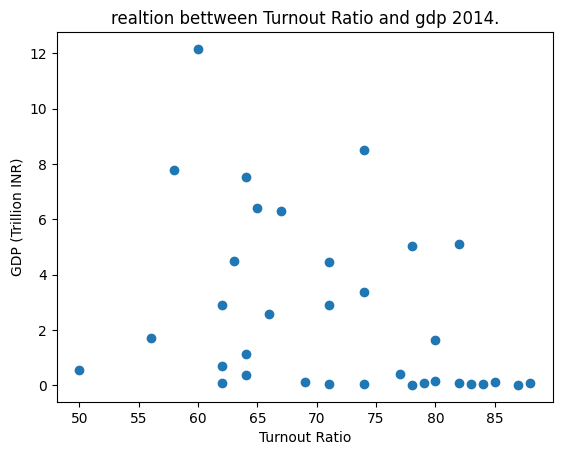

In [70]:
plt.scatter(final_dt["Turnout Ratio"],final_dt["GDP (Trillion INR)"])
plt.title('realtion bettween Turnout Ratio and gdp 2014.')
plt.xlabel('Turnout Ratio')
plt.ylabel('GDP (Trillion INR)')
plt.show()

In [71]:
data = {
    'state': ['Andhra Pradesh', 'Telangana', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
                 'Jammu & Kashmir', 'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
                 'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'West Bengal', 'Jharkhand', 'Uttarakhand',
                 'Andaman & Nicobar Islands', 'Chandigarh', 'Dadra & Nagar Haveli', 'Daman & Diu', 'NCT OF Delhi', 'Lakshadweep', 'Puducherry'],
    'GDP (Trillion INR)': [9.65, 5.17, 0.15, 3.59, 5.56, 0.41, 16.91, 8.87, 1.82,
                            1.26, 17.05, 8.68, 7.81, 27.22, 0.32, 0.39, 0.14, 0.22,
                            3.11, 11.70, 0.27, 10.55, 0.27, 14.47, 6.87, 1.28, 0.38,
                            0.10, 0.03, 0.06, 0.08, 0.71, 0.01, 0.04]
}


df_gdp = pd.DataFrame(data)

In [72]:
group = dt_2019.groupby("pc_name")

temp_df1 = group["total_votes"].sum().to_frame()

temp_df2 = group["total_electors"].apply(lambda x: x.mode().iloc[0]).to_frame()

temp_df3 = group["state"].apply(lambda x: x.unique()[0]).to_frame()

df = pd.merge(temp_df1,temp_df2, on = "pc_name")

df = pd.merge(df,temp_df3, on = "pc_name")

df.set_index("state", inplace = True)

df = df.groupby("state").sum()

df["Turnout Ratio"] = round((df["total_votes"] / df["total_electors"])*100)
df = df.reset_index()

In [73]:
final_dt = pd.merge(df[["state","Turnout Ratio"]],df_gdp[["state","GDP (Trillion INR)"]], on = "state")

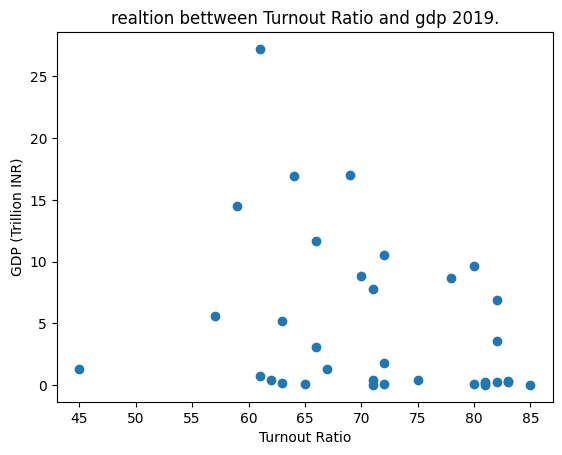

In [74]:
plt.scatter(final_dt["Turnout Ratio"],final_dt["GDP (Trillion INR)"])
plt.title('realtion bettween Turnout Ratio and gdp 2019.')
plt.xlabel('Turnout Ratio')
plt.ylabel('GDP (Trillion INR)')
plt.show()

In [75]:
data = {
    'Andhra Pradesh': 67.4,
    'Telangana': 66.5,
    'Arunachal Pradesh': 66.9,
    'Assam': 73.2,
    'Bihar': 63.8,
    'Goa': 88.7,
    'Gujarat': 78.0,
    'Haryana': 76.6,
    'Himachal Pradesh': 83.8,
    'Jammu & Kashmir': 68.7,
    'Karnataka': 75.0,
    'Kerala': 93.9,
    'Madhya Pradesh': 70.6,
    'Maharashtra': 82.3,
    'Manipur': 76.9,
    'Meghalaya': 74.4,
    'Mizoram': 91.6,
    'Nagaland': 79.6,
    'Punjab': 76.2,
    'Rajasthan': 67.1,
    'Sikkim': 82.2,
    'Tamil Nadu': 80.3,
    'Tripura': 87.8,
    'Uttar Pradesh': 69.7,
    'West Bengal': 77.1,
    'Jharkhand': 66.4,
    'Uttarakhand': 78.8,
    'Andaman & Nicobar Islands': 86.3,
    'Chandigarh': 86.1,
    'Dadra & Nagar Haveli': 77.1,
    'Daman & Diu': 81.6,
    'NCT OF Delhi': 86.3,
    'Lakshadweep': 92.2,
    'Puducherry': 85.9
}


df_litt = pd.DataFrame(list(data.items()), columns=['state', 'Value'])

In [76]:
group = dt_2014.groupby("pc_name")

temp_df1 = group["total_votes"].sum().to_frame()

temp_df2 = group["total_electors"].apply(lambda x: x.mode().iloc[0]).to_frame()

temp_df3 = group["state"].apply(lambda x: x.unique()[0]).to_frame()

df = pd.merge(temp_df1,temp_df2, on = "pc_name")

df = pd.merge(df,temp_df3, on = "pc_name")

df.set_index("state", inplace = True)

df = df.groupby("state").sum()

df["Turnout Ratio"] = round((df["total_votes"] / df["total_electors"])*100)
df = df.reset_index()

In [77]:
final_dt = pd.merge(df[["state","Turnout Ratio"]],df_litt[["state","Value"]], on = "state")

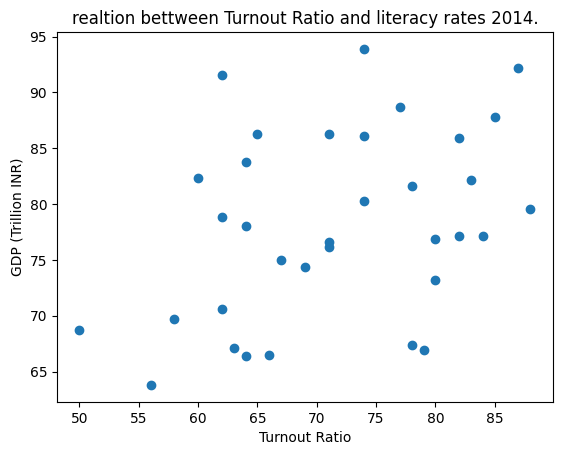

In [78]:
plt.scatter(final_dt["Turnout Ratio"],final_dt["Value"])
plt.title('realtion bettween Turnout Ratio and literacy rates 2014.')
plt.xlabel('Turnout Ratio')
plt.ylabel('GDP (Trillion INR)')
plt.show()

In [79]:
data = {
    'Andhra Pradesh': 67.41,
    'Telangana': 72.80,
    'Arunachal Pradesh': 65.38,
    'Assam': 72.19,
    'Bihar': 70.90,
    'Goa': 88.70,
    'Gujarat': 78.03,
    'Haryana': 77.60,
    'Himachal Pradesh': 83.78,
    'Jammu & Kashmir': 77.30,
    'Karnataka': 75.60,
    'Kerala': 96.20,
    'Madhya Pradesh': 73.70,
    'Maharashtra': 82.34,
    'Manipur': 76.94,
    'Meghalaya': 74.43,
    'Mizoram': 91.33,
    'Nagaland': 80.11,
    'Punjab': 76.70,
    'Rajasthan': 69.70,
    'Sikkim': 81.42,
    'Tamil Nadu': 80.09,
    'Tripura': 87.22,
    'Uttar Pradesh': 73.00,
    'West Bengal': 80.50,
    'Jharkhand': 67.63,
    'Uttarakhand': 79.63,
    'Andaman & Nicobar Islands': 86.27,
    'Chandigarh': 86.77,
    'Dadra & Nagar Haveli': 76.24,
    'Daman & Diu': 87.10,
    'NCT OF Delhi': 86.20,
    'Lakshadweep': 91.85,
    'Puducherry': 85.85
}


df_litt = pd.DataFrame(list(data.items()), columns=['state', 'Value'])

In [80]:
group = dt_2019.groupby("pc_name")

temp_df1 = group["total_votes"].sum().to_frame()

temp_df2 = group["total_electors"].apply(lambda x: x.mode().iloc[0]).to_frame()

temp_df3 = group["state"].apply(lambda x: x.unique()[0]).to_frame()

df = pd.merge(temp_df1,temp_df2, on = "pc_name")

df = pd.merge(df,temp_df3, on = "pc_name")

df.set_index("state", inplace = True)

df = df.groupby("state").sum()

df["Turnout Ratio"] = round((df["total_votes"] / df["total_electors"])*100)
df = df.reset_index()

In [81]:
final_dt = pd.merge(df[["state","Turnout Ratio"]],df_litt[["state","Value"]], on = "state")

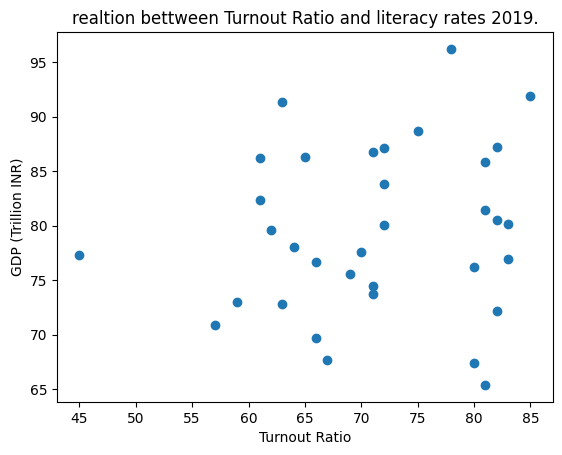

In [82]:
plt.scatter(final_dt["Turnout Ratio"],final_dt["Value"])
plt.title('realtion bettween Turnout Ratio and literacy rates 2019.')
plt.xlabel('Turnout Ratio')
plt.ylabel('GDP (Trillion INR)')
plt.show()